In [165]:
# imports

import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import preprocessing as prep
from faker import Faker

In [37]:
def process_strdollars(val):
    val=float(val.replace('$','').replace(',',''))
    return val

In [43]:
def conditional_log(val):
    if val!=0:
        val=np.log(val)
    return val

In [50]:
def impute_gender(row):
    val=0
    
    if row['Prefix is Mr.']==1:
        val=1
    elif row['Prefix is Ms.']==1:
        val=2
    elif row['Prefix is Mrs.']==1:
        val=2
    
    return val

In [149]:
def rec_mar_status(val):
    retval=val
    
    if pd.isna(val)==True:
        retval='NA'
    elif val not in ('M','U','S'):
        retval='O'
    return retval

# Retrieving Data

I doctored it in postgres so that I could do some window function work on the log of lhc.
As noted in the https://cooldata.files.wordpress.com/2018/01/cool-data-a-handbook-for-predictive-modeling.pdf ...
taming the lhc outlers by taking the log is a good move.
But we can also then do a decile on that log, can call it "lhc level", which will be a lot easier for a stakeholder to digest.

I also grouped the honorifics (e.g. "is Mr.") columns into an "imputed gender" category on the hunch that this would gather more explanatory power and was the analytic point of those categories anyway.  After which I dropped the honorific columns.

In [201]:
# retrieving sql output...

df = pd.read_csv('/Users/ouonomos/Documents/cool_unv_data2.tsv', sep='\t')
df.head()

,id_number,lifetimehc,email_present,busphone_present,grad_year,marital_status,spouseid_present,jobtitle_present,varsityath_present,studgovt_present,...,prefix_is_mr,prefix_is_ms,prefix_is_dr,prefix_is_mrs,lhc_clean,years_since_grad,imputed_gender,log_lhc,lhc_level,log_lhc_qrt
0,1053807,$0.25,1,0,2001,S,0,0,0,0,...,1,0,0,0,0.25,21,1,-0.60206,1,1
1,1053757,$0.25,0,0,2001,U,0,0,0,0,...,1,0,0,0,0.25,21,1,-0.60206,1,1
2,1078367,$0.00,1,0,2003,M,0,1,0,0,...,1,0,0,0,0.00,19,1,0.00000,1,1
3,1023190,$0.00,1,0,1979,M,0,1,0,0,...,0,0,0,0,0.00,43,0,0.00000,1,1
4,1053899,$0.00,0,0,2001,NaN,0,0,0,0,...,0,1,0,0,0.00,21,2,0.00000,1,1


# A Super Quick Intuition

## The Graduate Year Concept

If you were to look at the book noted above, you'd find that "year graduated" is in inverse correlation to the log of lhc, which makes sense ... you will have less money to donate if you haven't graduated, or haven't been earning as long as a graduate.  I turned "year graduated" into "years since grad" variable by subtracting it from 2022.

Now you see a positive relationship pictured below.  But it's suspicious ... a great bulk of the data points are very old.  We're going to have to be better informed about the meaning of this variable, and qualify it per some "still alive" or "years left to donate" principle.

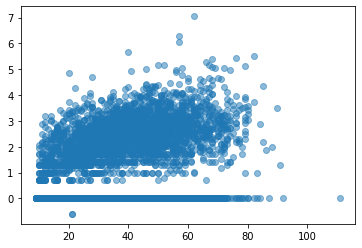

In [208]:
plt.scatter(df['years_since_grad'],df['log_lhc'], alpha=0.5)
plt.show()

## Continuing to Work Graduate Year Concept...

...nevertheless, we can use the "years since graduation" concept to illustrate sa general approach we can take.  The idea is to breakout levels of giving (here, quartiles of log LHC) by other explanatory categories, and look for areas of overlap.  For example, there is overlap in years since grad between log_lhc_quart where the spouse_id is present, with respect to min-max range of years_since_grad. 

What we're aiming for is something like "These donors are in the same earning window and have the same marital status, but are at a lower giving tier.  Maybe we should approach them."

In [221]:
table = pd.pivot_table(df, values=['years_since_grad'], index=['log_lhc_qrt', 'spouseid_present'],
                       aggfunc={'years_since_grad': ["min", "max"]})
table

years_since_grad    
                                          max min
log_lhc_qrt spouseid_present                     
1           0                             111   9
            1                              59  11
2           0                              92   9
            1                              68  11
3           0                              91  10
            1                              78  10
4           0                              90  11
            1                              79  15

In [202]:
df.columns

Index(['id_number', 'lifetimehc', 'email_present', 'busphone_present',
       'grad_year', 'marital_status', 'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present', 'prefix_is_mr', 'prefix_is_ms', 'prefix_is_dr',
       'prefix_is_mrs', 'lhc_clean', 'years_since_grad', 'imputed_gender',
       'log_lhc', 'lhc_level', 'log_lhc_qrt'],
      dtype='object')

# A Spot of Feature Engineering ...

Doing some onehot on marital the greatest frequencies of marital status after bucketing the small freq cats.

In [203]:
# recode for greatest frequency, keeping NaN
df['marital_status_rec']=df['marital_status'].apply(rec_mar_status)

df = pd.get_dummies(df, columns=['marital_status_rec'], dtype=int)
df.head()

,id_number,lifetimehc,email_present,busphone_present,grad_year,marital_status,spouseid_present,jobtitle_present,varsityath_present,studgovt_present,...,years_since_grad,imputed_gender,log_lhc,lhc_level,log_lhc_qrt,marital_status_rec_M,marital_status_rec_NA,marital_status_rec_O,marital_status_rec_S,marital_status_rec_U
0,1053807,$0.25,1,0,2001,S,0,0,0,0,...,21,1,-0.60206,1,1,0,0,0,1,0
1,1053757,$0.25,0,0,2001,U,0,0,0,0,...,21,1,-0.60206,1,1,0,0,0,0,1
2,1078367,$0.00,1,0,2003,M,0,1,0,0,...,19,1,0.00000,1,1,1,0,0,0,0
3,1023190,$0.00,1,0,1979,M,0,1,0,0,...,43,0,0.00000,1,1,1,0,0,0,0
4,1053899,$0.00,0,0,2001,NaN,0,0,0,0,...,21,2,0.00000,1,1,0,1,0,0,0


In [204]:
df.columns

Index(['id_number', 'lifetimehc', 'email_present', 'busphone_present',
       'grad_year', 'marital_status', 'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present', 'prefix_is_mr', 'prefix_is_ms', 'prefix_is_dr',
       'prefix_is_mrs', 'lhc_clean', 'years_since_grad', 'imputed_gender',
       'log_lhc', 'lhc_level', 'log_lhc_qrt', 'marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U'],
      dtype='object')

# Reviewing Correlation ...

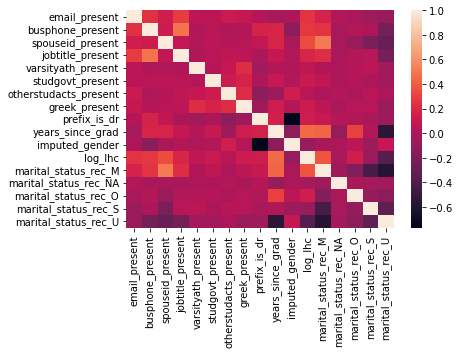

In [220]:


corr_eval_columns=['email_present', 'busphone_present',
       'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present','prefix_is_dr','years_since_grad','imputed_gender',
       'log_lhc','marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U']
sns.heatmap(df[corr_eval_columns].corr());

In [206]:
df[corr_eval_columns].corr()[['log_lhc']].sort_values(by='log_lhc', ascending=False)

,log_lhc
log_lhc,1.000000
years_since_grad,0.441914
marital_status_rec_M,0.369081
spouseid_present,0.337671
busphone_present,0.262517
email_present,0.240848
jobtitle_present,0.181078
marital_status_rec_O,0.141047
prefix_is_dr,0.122937
greek_present,0.118937


# Basic Multivar Regression

Exactly like the book.  This is never a bad exploration. Interestingly, my one-hot on marital_status_rec_M gives me more correlation, but a little less r2, presumably because spouseid_present is more general.

In [217]:
x_explain=df[['years_since_grad','spouseid_present','busphone_present','email_present']]
x_explain = sm.add_constant(x_explain)
ks = sm.OLS(df['log_lhc'],x_explain)
ks_res =ks.fit()
print(ks_res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_lhc   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     614.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:44:08   Log-Likelihood:                -7594.4
No. Observations:                5000   AIC:                         1.520e+04
Df Residuals:                    4995   BIC:                         1.523e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4651      0.041  